Generating PSK dataset across SNR levels...
Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2147 - loss: 1.8703 - val_accuracy: 0.2393 - val_loss: 1.7696
Epoch 2/40
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2419 - loss: 1.7668 - val_accuracy: 0.2414 - val_loss: 1.7658
Epoch 3/40
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2427 - loss: 1.7613 - val_accuracy: 0.2405 - val_loss: 1.7626
Epoch 4/40
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2437 - loss: 1.7584 - val_accuracy: 0.2385 - val_loss: 1.7637
Epoch 5/40
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2461 - loss: 1.7580 - val_accuracy: 0.2443 - val_loss: 1.7625
Epoch 6/40
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2497 - loss: 1.7538 - val_accuracy: 0.2409 - val_loss: 1.7663
Epoch 7/40
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2495 - loss: 1.7502 - val_accuracy: 0.2462 - val_loss: 1.7624
Epoch 8/40
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2511 - loss: 1.7512 - val_accurac

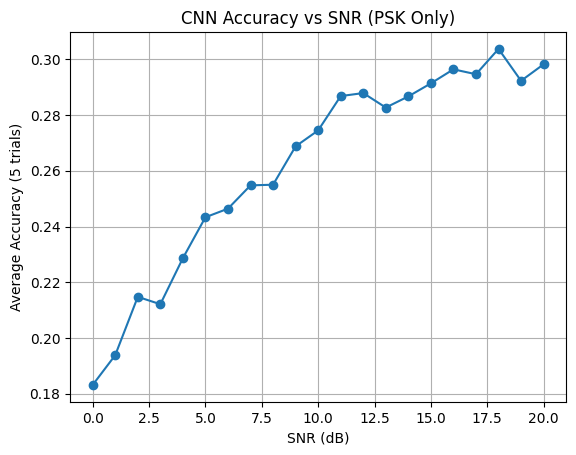

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def apply_channel(symbols, SNR_dB):
    Kr = 10
    power = 1
    s = np.sqrt((Kr / 2) * (Kr + 1) * power)
    sigma = power / np.sqrt(2 * (Kr + 1))
    avg_path_gains = np.array([0, -0.9, -4.9, -8, -7.8, -23.9])
    n_tap = len(avg_path_gains)

    tap_var = 10 ** (avg_path_gains / 10)
    tap_var = tap_var / np.sum(tap_var)

    hn1 = (1 / np.sqrt(2)) * (1 / np.sqrt(n_tap)) * sigma * np.sqrt(tap_var) * \
          ((np.random.randn(1, n_tap) + s) + 1j * (np.random.randn(1, n_tap) + s))

    faded_signal = np.zeros(len(symbols), dtype=complex)
    for i in range(n_tap):
        faded_signal += hn1[0, i] * np.roll(symbols, i)

    noise = (1 / np.sqrt(2)) * (np.random.randn(len(symbols)) + 1j * np.random.randn(len(symbols)))
    SNR_linear = 10 ** (SNR_dB / 10.0)
    noise_power = np.var(faded_signal) / SNR_linear
    noisy_symbols = faded_signal + np.sqrt(noise_power) * noise
    return noisy_symbols

def generate_psk(num_samples, SNR_dB, M):
    bits = np.random.randint(0, M, num_samples)
    angles = 2 * np.pi * bits / M
    symbols = np.exp(1j * angles)
    return apply_channel(symbols, SNR_dB)


def extract_cnn_features(signal, block_size=16):
    real = np.real(signal)
    imag = np.imag(signal)

    norm = np.max(np.abs(signal))
    real /= norm
    imag /= norm

    num_blocks = len(signal) // block_size
    features = []
    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size
        block = np.stack([real[start:end], imag[start:end]], axis=1)
        features.append(block)

    return np.array(features)

def build_dataset(num_samples, SNR_dB, block_size=16):
    modulations = [
        ("BPSK", 2), ("QPSK", 4), ("8PSK", 8),
        ("16PSK", 16), ("32PSK", 32),
        ("64PSK", 64), ("128PSK", 128), ("256PSK", 256)
    ]

    signals, labels = [], []
    for idx, (_, M) in enumerate(modulations):
        sig = generate_psk(num_samples, SNR_dB, M)
        feats = extract_cnn_features(sig, block_size)
        signals.append(feats)
        labels.append(np.full(len(feats), idx))

    X = np.vstack(signals)
    y = np.hstack(labels)
    return X, y


def create_model(block_size=64, num_classes=8):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(block_size, 2)),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


def evaluate_snr(model, SNR_dB, num_samples, block_size, trials):
    accs = []
    for _ in range(trials):
        X, y = build_dataset(num_samples, SNR_dB, block_size)
        _, acc = model.evaluate(X, y, verbose=0)
        accs.append(acc)
    return np.mean(accs)


if __name__ == "__main__":
    num_samples = 10000
    block_size = 16
    SNRs = range(0, 21)

    accuracies = []
    X_all, y_all = [], []

    print("Generating PSK dataset across SNR levels...")
    for SNR_dB in SNRs:
        X, y = build_dataset(num_samples, SNR_dB, block_size)
        X_all.append(X)
        y_all.append(y)

    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

    model = create_model(block_size, num_classes=8)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=40,
        batch_size=64,
        verbose=1
    )

    print("\nSNR vs Accuracy:")
    for SNR_dB in SNRs:
        acc = evaluate_snr(model, SNR_dB, num_samples, block_size, 5)
        accuracies.append(acc)
        print(f"{SNR_dB} dB -> {acc:.4f}")

    plt.figure()
    plt.plot(SNRs, accuracies, marker='o')
    plt.title("CNN Accuracy vs SNR (PSK Only)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Average Accuracy (5 trials)")
    plt.grid(True)
    plt.show()
